<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/AI_Agent_Bot_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langchain_groq langchain_community langgraph rizaio graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00


In [5]:
import os
from google.colab import userdata

groq_api_key=userdata.get('groq_api_key')
os.environ['RIZA_API_KEY']=userdata.get('RIZA_API_KEY')
os.environ['TAVILY_API_KEY']=userdata.get('TAVILY_API_KEY')

In [15]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.riza.command import ExecPython

In [16]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama-3.2-90b-vision-preview"
)

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7e30b965d660>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7e30b965e200>, model_name='llama-3.2-90b-vision-preview', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [17]:
llm.invoke('Hi, How are You?')

AIMessage(content="I'm just a computer program, so I don't have feelings, but thanks for asking. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 41, 'total_tokens': 68, 'completion_time': 0.096771385, 'prompt_time': 0.004491089, 'queue_time': 0.057204057, 'total_time': 0.101262474}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_07b97e5459', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce776f3c-9c0b-4153-954b-467d98a846ef-0', usage_metadata={'input_tokens': 41, 'output_tokens': 27, 'total_tokens': 68})

In [18]:
tools_tavily=TavilySearchResults(max_results=3)
tool_code_interpreter=ExecPython()
tools=[tools_tavily, tool_code_interpreter]

In [19]:
llm_with_tools = llm.bind_tools(tools=tools)

In [23]:
llm_with_tools.invoke('Give me current Trending events in USA?')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m8m5', 'function': {'arguments': '{"query": "current trending events in USA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 416, 'total_tokens': 438, 'completion_time': 0.07952357, 'prompt_time': 0.049464557, 'queue_time': 0.056750431999999996, 'total_time': 0.128988127}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_07b97e5459', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d2163fbd-86c5-4a2d-9066-a5140bbd9468-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current trending events in USA'}, 'id': 'call_m8m5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 416, 'output_tokens': 22, 'total_tokens': 438})

In [24]:
response = llm.invoke('''
### What is the output of print(['a']+[2])
''')

if hasattr(response, 'content'):
  print('AI response Content:', response.content)
else:
  print('AI Response:',response)

AI response Content: The output of `print(['a'] + [2])` will be:

```python
['a', 2]
```

In Python, the `+` operator is used for concatenation when working with lists. It combines the elements of the two lists into a new list. The result is a new list that contains all elements from both lists. 

Here's an explanation of what happens:

- `['a']` is a list containing a single string element 'a'.
- `[2]` is a list containing a single integer element 2.
- When you use the `+` operator to combine these two lists, Python concatenates them, resulting in a new list `['a', 2]`. 

Note that the type of the elements in the resulting list can be mixed, as shown in this example where the list contains both a string and an integer.


In [25]:
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [26]:
# Define a chatbot function that takes a state as input and returns a new state with updated messages
def chatbot(state: State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]} ## Invoke the LLM on the Input messages

In [27]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools","chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile()

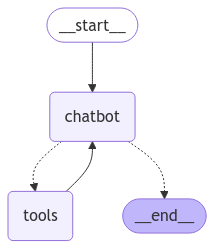

In [28]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  display(Image(graph.get_graph().draw_graphviz_png()))

In [29]:
def stream_graph_updates(user_input:str):
  """
  Streams updates from the compiled graph based on user input.

  Args:
    user_input (str): The user's input message.

  Prints:
    str: The assistant's response message.
  """

  initial_state = {"messages":[("user",user_input)]}

  for event in graph.stream(initial_state):
    for value in event.values():
      print("Assistant:", value["messages"][-1].content)

In [30]:
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit","exit","q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input)
  except Exception as e:
    print("Exceptions occured during processing:",e)
    stream_graph_updates(user_input)
    break

User: What is Latest news in Tirupati.
Assistant: 
Assistant: [{"url": "https://www.hindustantimes.com/india-news/when-police-opened-the-gates-eyewitness-recounts-moments-before-tirupati-stampede-101736397365074.html", "content": "Six pilgrims died, while over 40 were left injured in a stampede in Andhra Pradesh's Tirupati on Wednesday evening. After the incident,"}, {"url": "https://www.youtube.com/watch?v=-nrvDJh-5eo", "content": "At least 6 persons lost their lives and several others sustained injuries after a stampede broke out at the Tirupati Temple on January 08."}, {"url": "https://www.youtube.com/watch?v=s_PtXUyTtbs", "content": "Tirupati Stampede Latest Updates: Six people died in a stampede ... Follow us on Google News for Breaking and Latest News Updates: NDTV"}]
Assistant: The latest news in Tirupati is about a stampede that occurred at the Tirupati Temple on January 08, resulting in the deaths of at least 6 people and injuries to several others.
User: What is Latest news i